## Построение графа попарного косинусного сходства векторизированных чанков документа 

### Установка зависимостей

In [ ]:
# установка langchain зависимостей
%pip install langchain langchain-community langchain-text-splitters langchain-huggingface langchain-chroma

In [ ]:
# установка остального по
%pip install pypdf networkx numpy matplotlib

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from langchain_core.documents import Document
import textwrap

def preview_doc(doc: Document, max_length=100):
  '''Метод для сжатия вывода контента документов.'''
  short_metadata = textwrap.shorten(str(doc.metadata), width=max_length, placeholder='…')
  short_content = textwrap.shorten(doc.page_content, width=max_length, placeholder='…')
  return f"Document(metadata={short_metadata}, page_content='{short_content}')"

### Подготовка данных

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# загружаем PDF файл
loader = PyPDFLoader('https://www.cs.princeton.edu/~arvindn/publications/OpenWPM_1_million_site_tracking_measurement.pdf')
pages = loader.load()
preview_doc(pages[0])

"Document(metadata={'producer': 'pdfTeX-1.40.16', 'creator': 'LaTeX with hyperref package', 'creationdate':…, page_content='Online Tracking: A 1-million-site Measurement and Analysis Steven Englehardt Princeton University…')"

In [ ]:
from unstructured.cleaners.core import clean

# зачищаем текст от мусора
for page in pages:
  page.page_content = clean(page.page_content, extra_whitespace=True, dashes=True, bullets=True, lowercase=False)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# разбиваем PDF на чанки
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = text_splitter.split_documents(pages)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# выбираем модель для создания эмбеддингов
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

embedding_model = HuggingFaceEmbeddings(
  model_name=model_name,
  model_kwargs=model_kwargs,
  encode_kwargs=encode_kwargs
)

In [ ]:
from langchain_chroma import Chroma

# инициализируем векторную базу
db = Chroma.from_documents(documents=splits, embedding=embedding_model)

In [ ]:
# получаем все документы, эмбеддинги и id из коллекции
data = db.get(include=['embeddings', 'documents', 'metadatas'])
ids = data['ids']
embeddings = data['embeddings']
documents = data['documents']
metadatas = data['metadatas']

### Считаем попарное косинусное сходство

In [ ]:
import numpy as np

def cosine_similarity(X, Y=None):
  if Y is None:
    Y = X

  X = np.array(X)
  Y = np.array(Y)
  X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
  Y_norm = Y / np.linalg.norm(Y, axis=1, keepdims=True)
  return np.dot(X_norm, Y_norm.T)


sim_matrix = cosine_similarity(embeddings)

### Строим граф

In [ ]:
import networkx as nx

G = nx.Graph()

# загоняем чанки как узлы
for i, (doc_id, text, meta) in enumerate(zip(ids, documents, metadatas)):
  G.add_node(doc_id, **meta)

THRESHOLD = 0.8

# добавляем рёбра, если сходство выше порога
n = len(ids)
for i in range(n):
  for j in range(i + 1, n):
    if sim_matrix[i, j] > THRESHOLD:
      G.add_edge(ids[i], ids[j], weight=sim_matrix[i, j])

### Выводим на экран

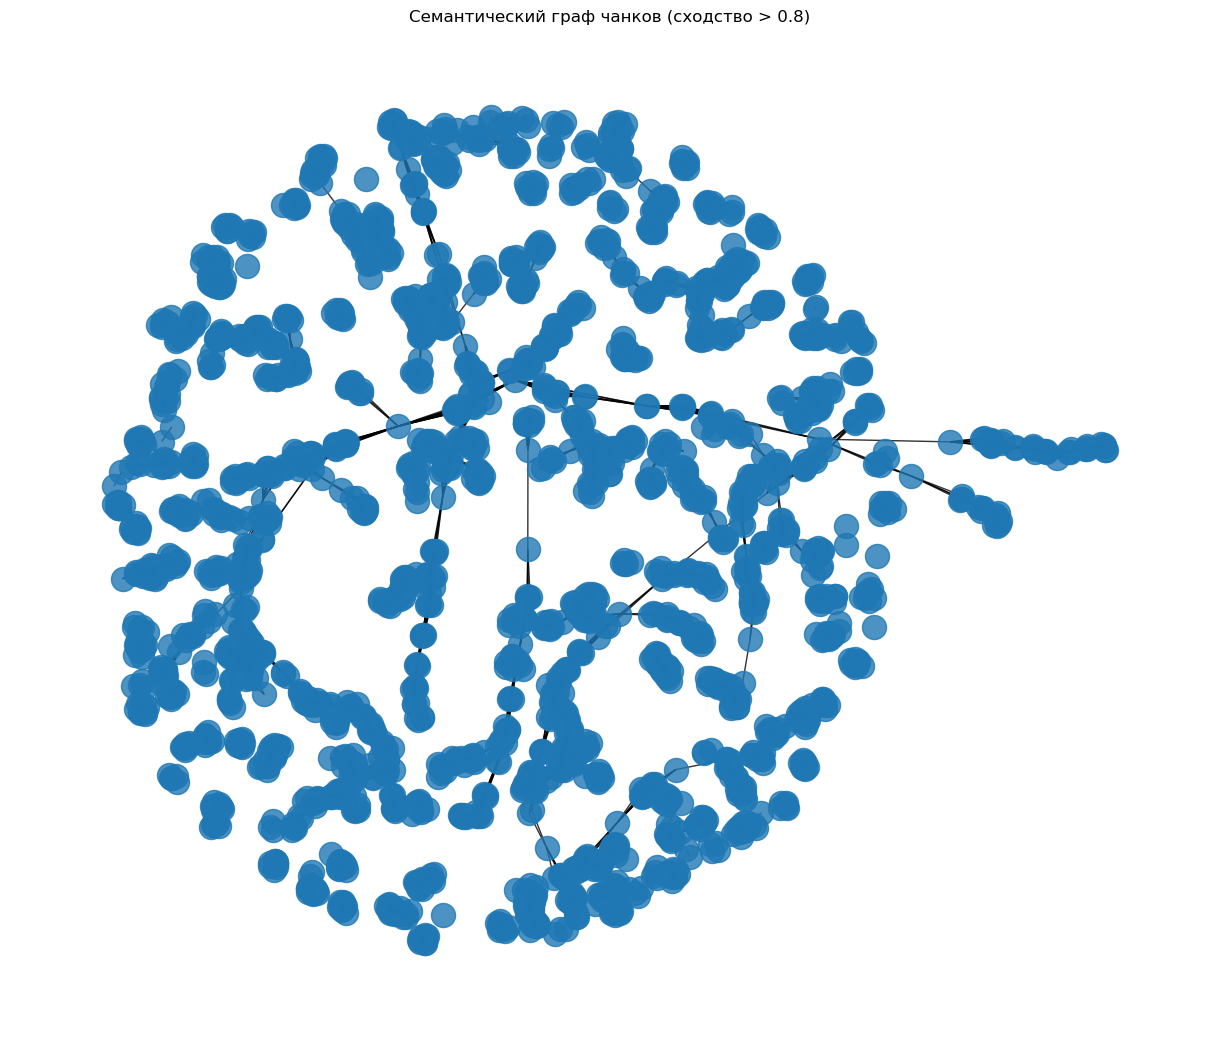

In [ ]:
import matplotlib.pyplot as plt

SEED = 42

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=SEED)
plt.figure(figsize=(12, 10))
nx.draw(G, pos, node_size=300, with_labels=False, alpha=0.8)
plt.title(f'Семантический граф чанков (сходство > {THRESHOLD})')
plt.show()

<img src="https://media1.tenor.com/m/veM7Wd7HmnMAAAAC/shylily-raf.gif" />